###CLASSIFIER A

Label counts for Classifier A:
  Class 0 (Prompt collapse (<2 ms)): 137 samples
  Class 1 (NS remnant (else or NaN)): 261 samples

Classifier A (Validation Set):
Accuracy: 0.9375, MCC: 0.8618
              precision    recall  f1-score   support

      Prompt       0.93      0.89      0.91        28
  NS remnant       0.94      0.96      0.95        52

    accuracy                           0.94        80
   macro avg       0.93      0.93      0.93        80
weighted avg       0.94      0.94      0.94        80


Classifier A (Total Set):
Accuracy: 0.9673, MCC: 0.9275


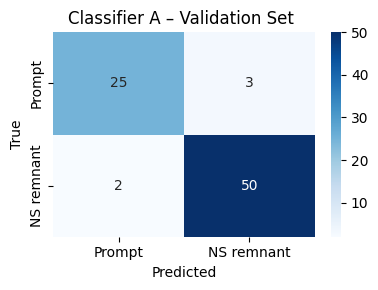

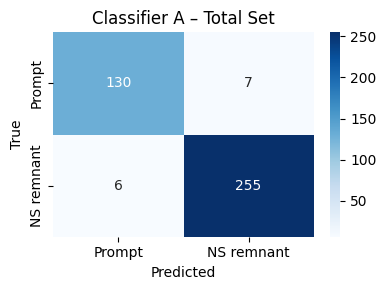

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load dataset ===
df = pd.read_json("dataset_classA.json")

# === Step 2: Paper-aligned labels ===
# 0 = Prompt collapse (tau < 2 ms = 0.002 s)
# 1 = NS remnant (everything else, INCLUDING no-collapse / NaN)
def map_label_A(row):
    ct = row["CollapseTime"]
    if pd.notna(ct) and ct < 0.002:
        return 0
    return 1

df["label_A"] = df.apply(map_label_A, axis=1)

# === Step 3: Show label counts ===
print("Label counts for Classifier A:")
label_names = {0: "Prompt collapse (<2 ms)", 1: "NS remnant (else or NaN)"}
for label, count in df["label_A"].value_counts().sort_index().items():
    print(f"  Class {label} ({label_names[label]}): {count} samples")

# === Step 4: Select features and labels ===
# Must match training features used in the paper
features = ["Mtot", "Mratio_fixed", "LambdaTilde", "ChiEff"]
X = df[features].copy()
y = df["label_A"].copy()

# Defensive cleaning for any stray inf/nan in features
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # keep labels aligned with rows kept

# === Step 5: Train-validation split (stratified) ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 6: Scale ===
scaler_A = StandardScaler()
X_train_scaled = scaler_A.fit_transform(X_train)
X_val_scaled   = scaler_A.transform(X_val)
X_all_scaled   = scaler_A.transform(X)

# === Step 7: Train model (GBDT with early stopping; paper-consistent ranges) ===
model_A = GradientBoostingClassifier(
    n_estimators=100,        # ~100 typical in paper
    learning_rate=0.1,      # typical
    max_depth=3,            # <5
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-4
)
model_A.fit(X_train_scaled, y_train)

# === Step 8: Evaluate on validation set ===
y_val_pred = model_A.predict(X_val_scaled)
acc_val = accuracy_score(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)

print("\nClassifier A (Validation Set):")
print(f"Accuracy: {acc_val:.4f}, MCC: {mcc_val:.4f}")
print(classification_report(y_val, y_val_pred, target_names=["Prompt", "NS remnant"]))

# === Step 9: Evaluate on total set ===
X_all_pred = model_A.predict(X_all_scaled)
acc_all = accuracy_score(y, X_all_pred)
mcc_all = matthews_corrcoef(y, X_all_pred)

print("\nClassifier A (Total Set):")
print(f"Accuracy: {acc_all:.4f}, MCC: {mcc_all:.4f}")

# === Step 10: Confusion Matrices ===
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Prompt", "NS remnant"], yticklabels=["Prompt", "NS remnant"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_val, y_val_pred, "Classifier A – Validation Set ")
plot_confusion(y, X_all_pred, "Classifier A – Total Set")

###CLASSIFIER B

Label counts for Classifier B:
label_B
0    137
1    160
2     21
Name: count, dtype: int64

Classifier B (Validation Set):
Accuracy: 0.9375, MCC: 0.8901
              precision    recall  f1-score   support

      Prompt       0.93      0.96      0.95        28
        HMNS       0.97      0.91      0.94        32
  NoCollapse       0.80      1.00      0.89         4

    accuracy                           0.94        64
   macro avg       0.90      0.96      0.92        64
weighted avg       0.94      0.94      0.94        64


Classifier B (Total Set):
Accuracy: 0.9843, MCC: 0.9720


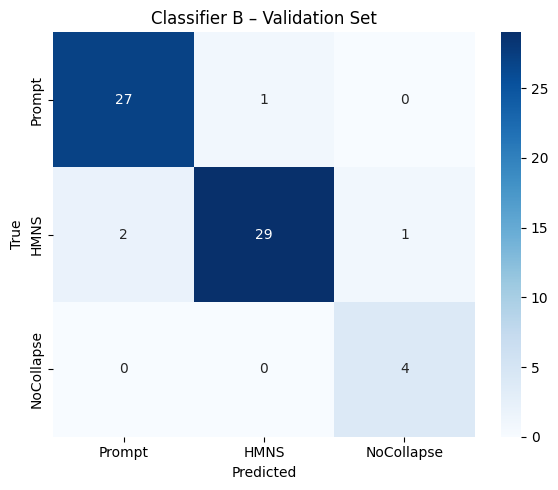

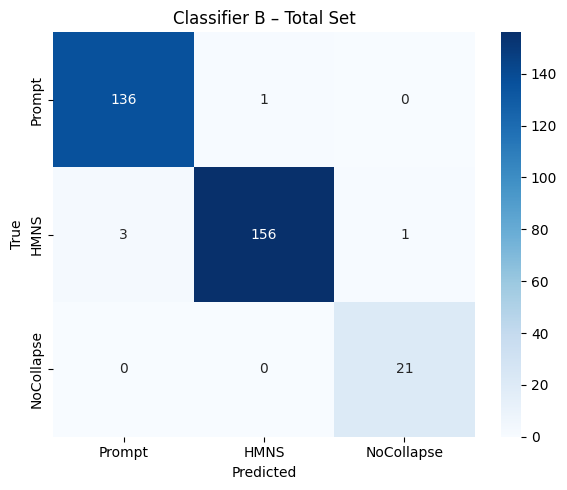

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load dataset ===
df = pd.read_json("dataset_classBandC.json")

# CollapseTime expected in seconds. If in ms, uncomment:
# df["CollapseTime"] = df["CollapseTime"] / 1000.0

# Optional: drop ambiguous "no collapse" if post-merger sim time < 25 ms (if column exists)
if "t_sim_postmerger_ms" in df.columns:
    mask_ambiguous = df["CollapseTime"].isna() & (df["t_sim_postmerger_ms"] < 25)
    df = df.loc[~mask_ambiguous].copy()

# === Step 2: Labels (B: 0=Prompt (<2 ms), 1=HMNS (collapses during sim), 2=No collapse within sim time) ===
def map_label_B(row):
    ct = row["CollapseTime"]
    if pd.isna(ct):
        return 2  # no collapse within simulation time
    if ct < 0.002:
        return 0  # prompt
    return 1      # HMNS (collapses during sim, >=2 ms)

df["label_B"] = df.apply(map_label_B, axis=1)

# === Step 3: Show label counts ===
print("Label counts for Classifier B:")
print(df["label_B"].value_counts().sort_index())

# === Step 4: Features & labels ===
features = ["Mtot", "Mratio_fixed", "LambdaTilde", "ChiEff"]
X = df[features].copy()
y = df["label_B"].copy()

# Clean inf/nan
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

# === Step 5: Train/val split (stratified) ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 6: Scale ===
scaler_B = StandardScaler()
X_train_scaled = scaler_B.fit_transform(X_train)
X_val_scaled   = scaler_B.transform(X_val)
X_all_scaled   = scaler_B.transform(X)

# === Step 7: Train model (GBDT with early stopping) ===
model_B = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-4
)
model_B.fit(X_train_scaled, y_train)

# === Step 8: Evaluate on validation set ===
y_val_pred = model_B.predict(X_val_scaled)
acc_val = accuracy_score(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)
print("\nClassifier B (Validation Set):")
print(f"Accuracy: {acc_val:.4f}, MCC: {mcc_val:.4f}")
print(classification_report(y_val, y_val_pred, target_names=["Prompt", "HMNS", "NoCollapse"]))

# === Step 9: Evaluate on full dataset ===
y_all_pred = model_B.predict(X_all_scaled)
acc_all = accuracy_score(y, y_all_pred)
mcc_all = matthews_corrcoef(y, y_all_pred)
print("\nClassifier B (Total Set):")
print(f"Accuracy: {acc_all:.4f}, MCC: {mcc_all:.4f}")

# === Step 10: Confusion matrices ===
def plot_conf(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Prompt", "HMNS", "NoCollapse"],
                yticklabels=["Prompt", "HMNS", "NoCollapse"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_conf(y_val, y_val_pred, "Classifier B – Validation Set")
plot_conf(y, y_all_pred, "Classifier B – Total Set")

###CLASSIFIER C


Classifier C (Validation Set):
Accuracy: 0.8281, MCC: 0.7339
              precision    recall  f1-score   support

      Prompt       0.89      0.89      0.89        28
       Short       0.57      0.57      0.57         7
        Long       0.83      0.80      0.82        25
  NoCollapse       0.80      1.00      0.89         4

    accuracy                           0.83        64
   macro avg       0.77      0.82      0.79        64
weighted avg       0.83      0.83      0.83        64


Classifier C (Total Set):
Accuracy: 0.9308, MCC: 0.8929


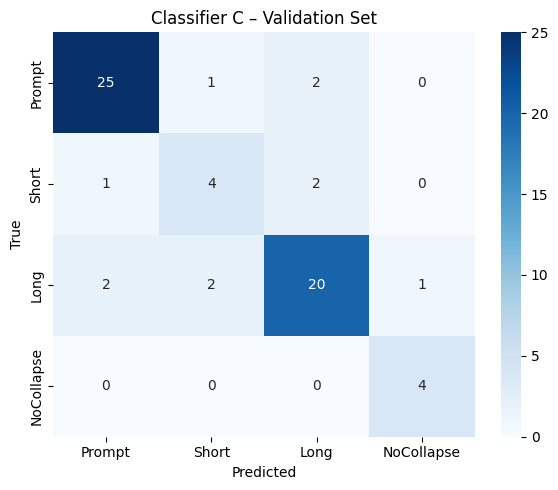

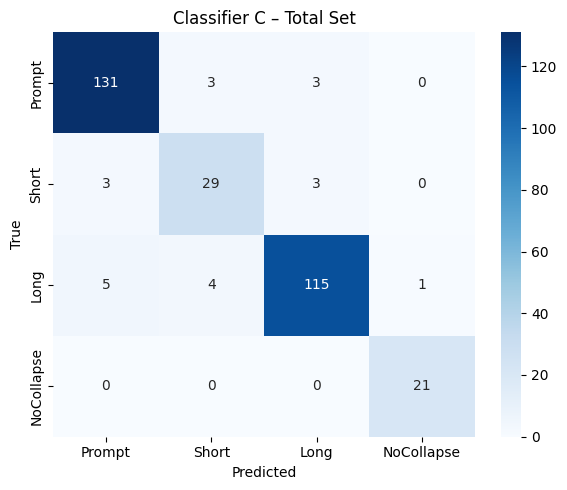

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load dataset ===
df = pd.read_json("dataset_classBandC.json")

# CollapseTime expected in seconds. If in ms, uncomment:
# df["CollapseTime"] = df["CollapseTime"] / 1000.0

# Optional: drop ambiguous "no collapse" if post-merger sim time < 25 ms (if column exists)
if "t_sim_postmerger_ms" in df.columns:
    mask_ambiguous = df["CollapseTime"].isna() & (df["t_sim_postmerger_ms"] < 25)
    df = df.loc[~mask_ambiguous].copy()

# === Step 2: Labels (C: 0=Prompt <2ms, 1=Short 2–5ms, 2=Long >5ms, 3=No collapse within sim time) ===
def map_label_C(row):
    ct = row["CollapseTime"]
    if pd.isna(ct):
        return 3  # no collapse within simulation time
    if ct < 0.002:
        return 0  # prompt
    if ct < 0.005:
        return 1  # short-lived HMNS (2–5 ms)
    return 2      # long-lived HMNS (>5 ms, collapses during sim)

df["label_C"] = df.apply(map_label_C, axis=1)

# === Step 3: Features & labels ===
features = ["Mtot", "Mratio_fixed", "LambdaTilde", "ChiEff"]
X = df[features].copy()
y = df["label_C"].copy()

# Clean inf/nan
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

# === Step 4: Train/val split (stratified) ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 5: Scale ===
scaler_C = StandardScaler()
X_train_scaled = scaler_C.fit_transform(X_train)
X_val_scaled   = scaler_C.transform(X_val)
X_all_scaled   = scaler_C.transform(X)

# === Step 6: Train model (GBDT with early stopping) ===
model_C = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-4
)
model_C.fit(X_train_scaled, y_train)

# === Step 7: Evaluate on validation set ===
y_val_pred = model_C.predict(X_val_scaled)
acc_val = accuracy_score(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)
print("\nClassifier C (Validation Set):")
print(f"Accuracy: {acc_val:.4f}, MCC: {mcc_val:.4f}")
print(classification_report(y_val, y_val_pred,
                            target_names=["Prompt", "Short", "Long", "NoCollapse"]))

# === Step 8: Evaluate on full dataset ===
y_all_pred = model_C.predict(X_all_scaled)
acc_all = accuracy_score(y, y_all_pred)
mcc_all = matthews_corrcoef(y, y_all_pred)
print("\nClassifier C (Total Set):")
print(f"Accuracy: {acc_all:.4f}, MCC: {mcc_all:.4f}")

# === Step 9: Confusion matrices ===
def plot_conf(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Prompt", "Short", "Long", "NoCollapse"],
                yticklabels=["Prompt", "Short", "Long", "NoCollapse"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_conf(y_val, y_val_pred, "Classifier C – Validation Set")
plot_conf(y, y_all_pred, "Classifier C – Total Set")

###PREDICTIONS

In [26]:
import pandas as pd
import numpy as np
from collections import Counter

# === Step 1: Load posterior CSV ===
df_17 = pd.read_csv("GW170817_result.posterior.csv")

# === Step 2: Compute derived GW features (source-frame masses) ===
# Using already source-frame values
df_17["Mtot"] = df_17["mass_1_source"] + df_17["mass_2_source"]
df_17["Mratio_fixed"] = df_17["mass_1_source"] / df_17["mass_2_source"]

df_17["LambdaTilde"] = (
    (16.0 / 13.0) * (
        (df_17["mass_1_source"] + 12 * df_17["mass_2_source"]) * df_17["lambda_1"] +
        (df_17["mass_2_source"] + 12 * df_17["mass_1_source"]) * df_17["lambda_2"]
    ) / (df_17["Mtot"] ** 5)
)

df_17["ChiEff"] = (
    df_17["mass_1_source"] * df_17["a_1"] * df_17["cos_tilt_1"] +
    df_17["mass_2_source"] * df_17["a_2"] * df_17["cos_tilt_2"]
) / df_17["Mtot"]

# === Step 3: Select cleaned features ===
features = ["Mtot", "Mratio_fixed", "LambdaTilde", "ChiEff"]
df_17 = df_17[features].replace([np.inf, -np.inf], np.nan).dropna()

# === Step 4: Scale ===
X_17_A = scaler_A.transform(df_17)
X_17_B = scaler_B.transform(df_17)
X_17_C = scaler_C.transform(df_17)

# === Step 5: Predict ===
pred_17_A = model_A.predict(X_17_A)
pred_17_B = model_B.predict(X_17_B)
pred_17_C = model_C.predict(X_17_C)

prob_17_A = model_A.predict_proba(X_17_A)
prob_17_B = model_B.predict_proba(X_17_B)
prob_17_C = model_C.predict_proba(X_17_C)

# === Step 6: Display ===
print("\n--- GW170817 Predictions ---")
print("Classifier A:", dict(Counter(pred_17_A)))
print("Classifier B:", dict(Counter(pred_17_B)))
print("Classifier C:", dict(Counter(pred_17_C)))


--- GW170817 Predictions ---
Classifier A: {np.int64(0): 87674, np.int64(1): 985}
Classifier B: {np.int64(0): 87672, np.int64(1): 987}
Classifier C: {np.int64(0): 88267, np.int64(2): 257, np.int64(1): 135}


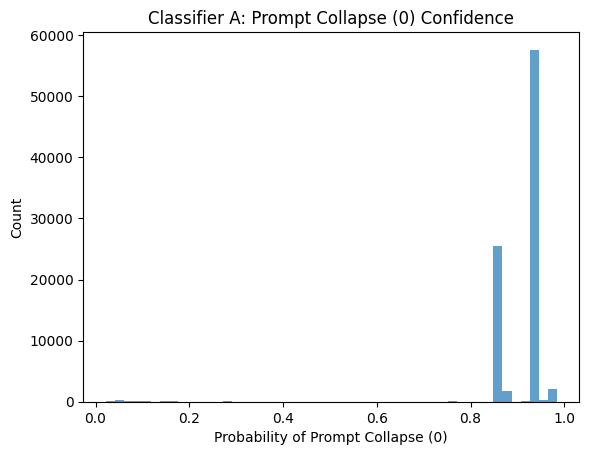

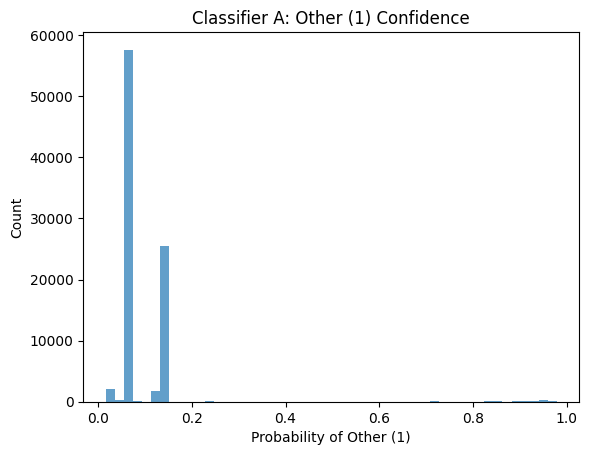

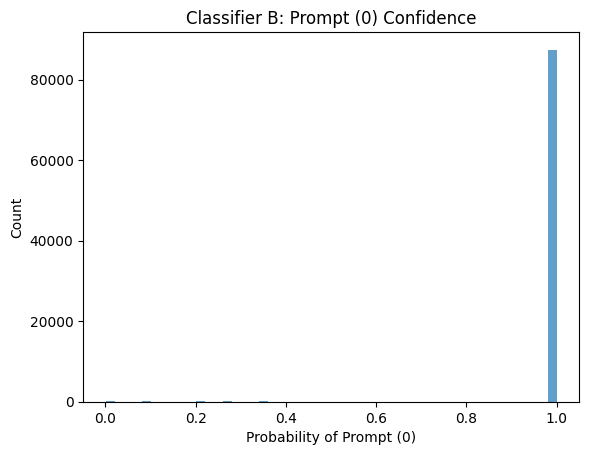

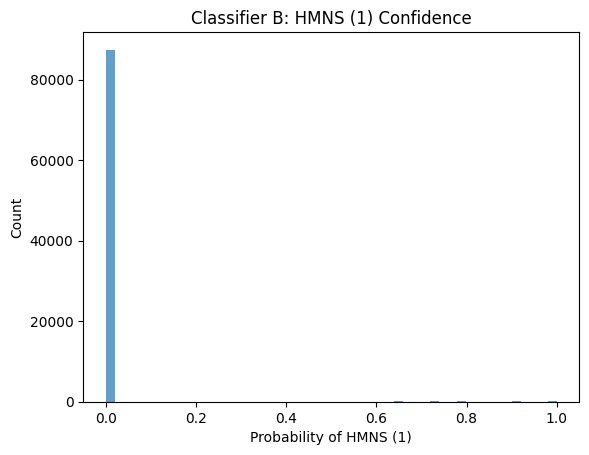

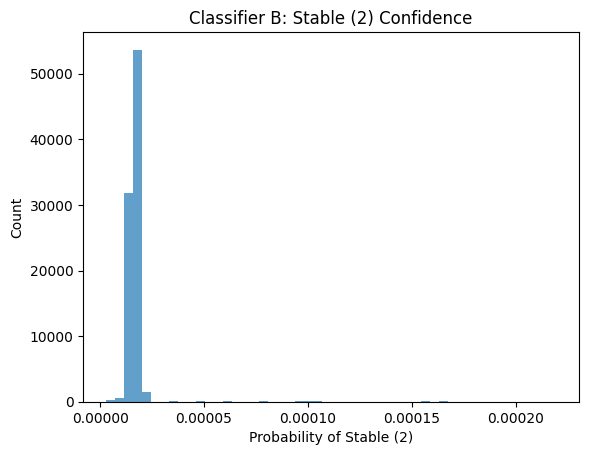

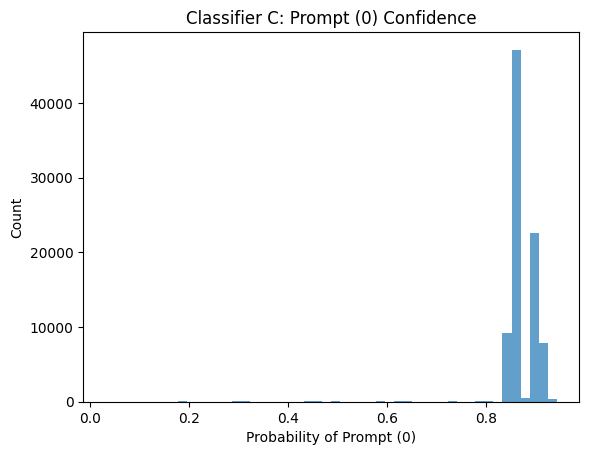

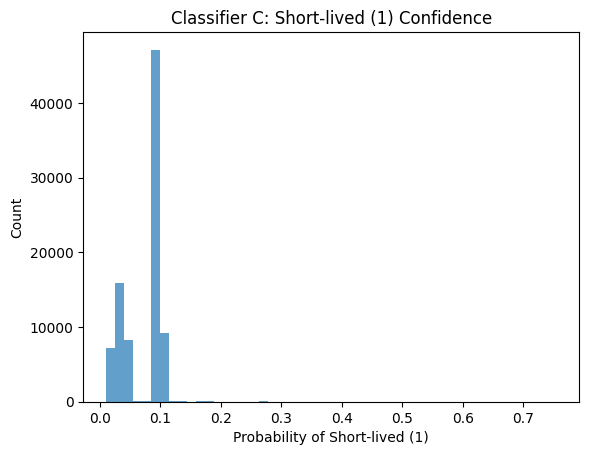

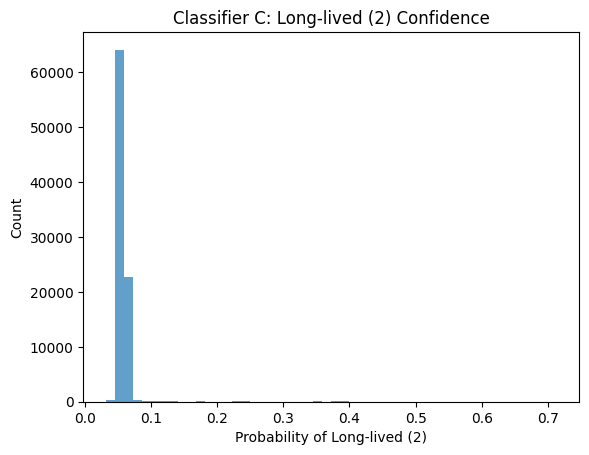

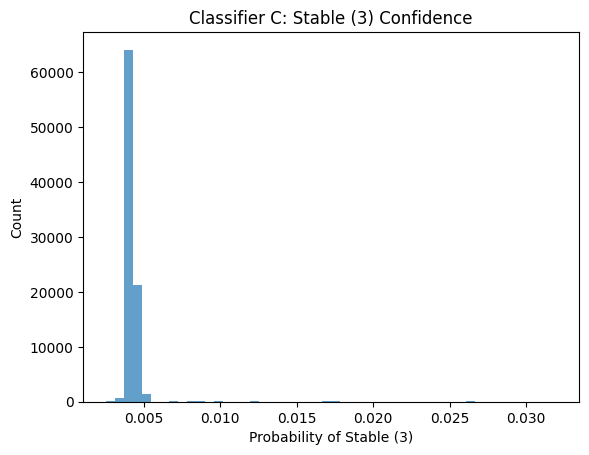

In [27]:
import matplotlib.pyplot as plt

# === Labels for each classifier ===
labels_A = ["Prompt Collapse (0)", "Other (1)"]
labels_B = ["Prompt (0)", "HMNS (1)", "Stable (2)"]
labels_C = ["Prompt (0)", "Short-lived (1)", "Long-lived (2)", "Stable (3)"]

probs = [prob_17_A, prob_17_B, prob_17_C]
titles = [labels_A, labels_B, labels_C]
clf_names = ["Classifier A", "Classifier B", "Classifier C"]

# === Plot histograms ===
for i, (prob, label_list, name) in enumerate(zip(probs, titles, clf_names)):
    for j, label in enumerate(label_list):
        plt.hist(prob[:, j], bins=50, alpha=0.7)
        plt.xlabel(f"Probability of {label}")
        plt.ylabel("Count")
        plt.title(f"{name}: {label} Confidence")
        plt.show()

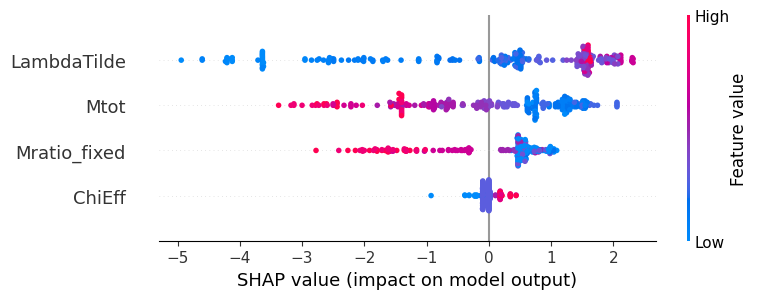

In [28]:
import shap

explainer = shap.Explainer(model_A, X_train_scaled)
shap_values = explainer(X_train_scaled)

shap.summary_plot(shap_values, features=X_train, feature_names=features)

####EVENT+EoS

In [29]:
import pandas as pd
import numpy as np
from collections import Counter

# --- Load EoS-conditioned posterior samples ---
df_eos = pd.read_csv("EoS.csv")

# Map your column names to what we need
m1 = df_eos["m1_source_frame_Msun"].astype(float)
m2 = df_eos["m2_source_frame_Msun"].astype(float)
lam1 = df_eos["Lambda1"].astype(float)
lam2 = df_eos["Lambda2"].astype(float)

# --- Derived features (source-frame masses) ---
Mtot_eos = m1 + m2
Mratio_fixed_eos = m1 / m2

LambdaTilde_eos = (
    (16.0/13.0) * ((m1 + 12.0*m2) * lam1 + (m2 + 12.0*m1) * lam2) / (Mtot_eos**5)
)

# ChiEff: use spins if present; otherwise assume ~low spins -> 0
if {"a_1","a_2","cos_tilt_1","cos_tilt_2"}.issubset(df_eos.columns):
    chi_eff_eos = (
        m1 * df_eos["a_1"].astype(float) * df_eos["cos_tilt_1"].astype(float) +
        m2 * df_eos["a_2"].astype(float) * df_eos["cos_tilt_2"].astype(float)
    ) / Mtot_eos
else:
    chi_eff_eos = np.zeros(len(df_eos), dtype=float)
    print("Note: No spin columns in EoS.csv; setting ChiEff = 0 for all samples.")

# Build feature matrix
features_eos_cols = ["Mtot", "Mratio_fixed", "LambdaTilde", "ChiEff"]
X_df_eos = pd.DataFrame({
    "Mtot": Mtot_eos,
    "Mratio_fixed": Mratio_fixed_eos,
    "LambdaTilde": LambdaTilde_eos,
    "ChiEff": chi_eff_eos,
}).replace([np.inf, -np.inf], np.nan).dropna()

# --- Scale ---
X_eos_A = scaler_A.transform(X_df_eos)
X_eos_B = scaler_B.transform(X_df_eos)
X_eos_C = scaler_C.transform(X_df_eos)

# --- Predict ---
pred_eos_A = model_A.predict(X_eos_A)
pred_eos_B = model_B.predict(X_eos_B)
pred_eos_C = model_C.predict(X_eos_C)

prob_eos_A = model_A.predict_proba(X_eos_A)
prob_eos_B = model_B.predict_proba(X_eos_B)
prob_eos_C = model_C.predict_proba(X_eos_C)

print("\n--- GW170817 + EoS (from EoS.csv) ---")
print("Classifier A:", dict(Counter(pred_eos_A)))
print("Classifier B:", dict(Counter(pred_eos_B)))
print("Classifier C:", dict(Counter(pred_eos_C)))

Note: No spin columns in EoS.csv; setting ChiEff = 0 for all samples.

--- GW170817 + EoS (from EoS.csv) ---
Classifier A: {np.int64(0): 2905, np.int64(1): 16}
Classifier B: {np.int64(0): 2902, np.int64(1): 19}
Classifier C: {np.int64(0): 2916, np.int64(1): 3, np.int64(2): 2}


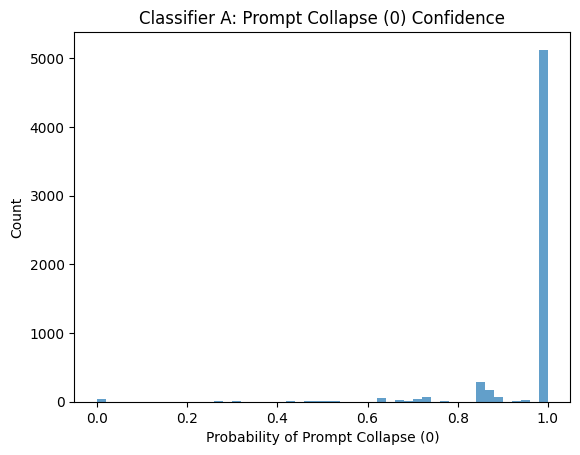

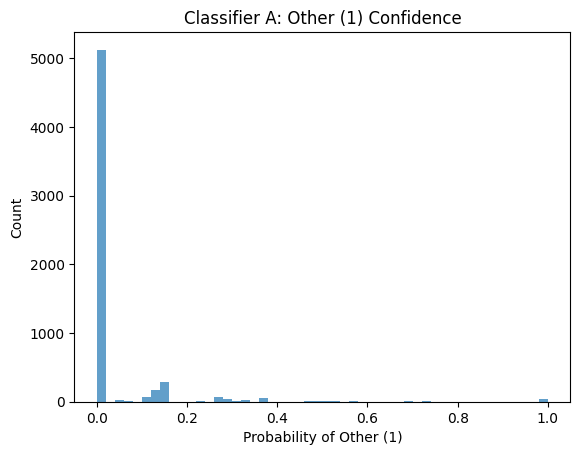

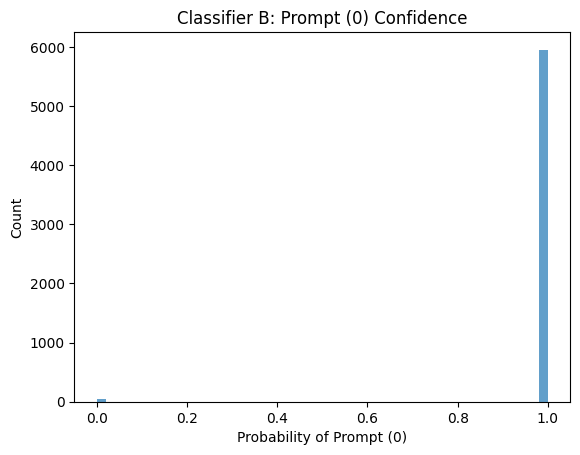

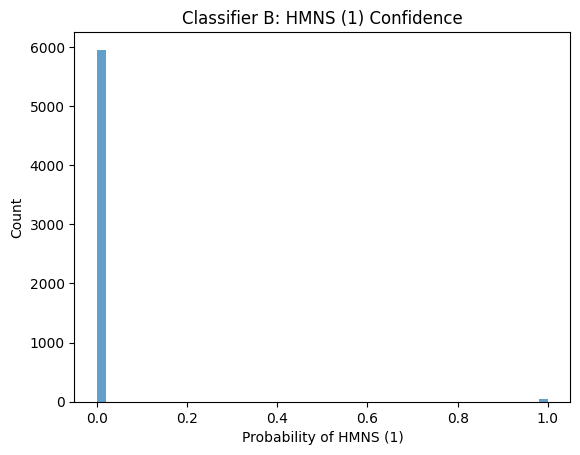

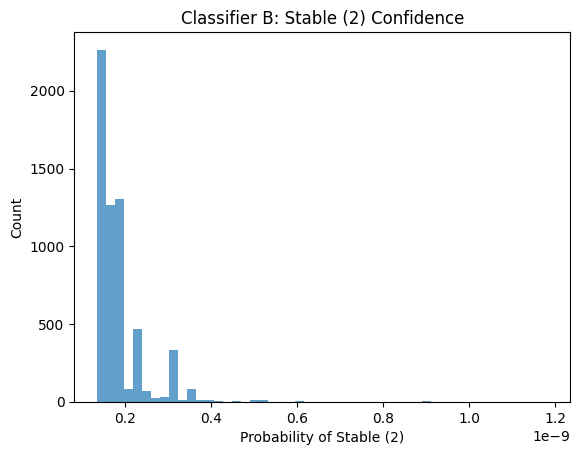

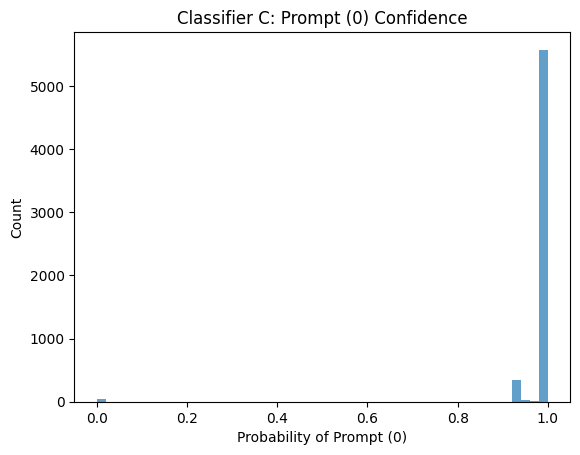

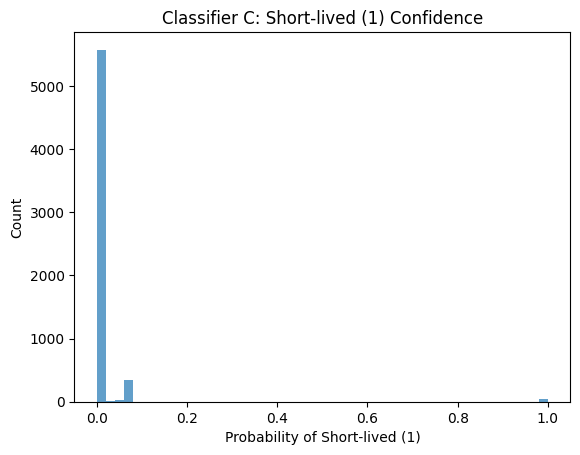

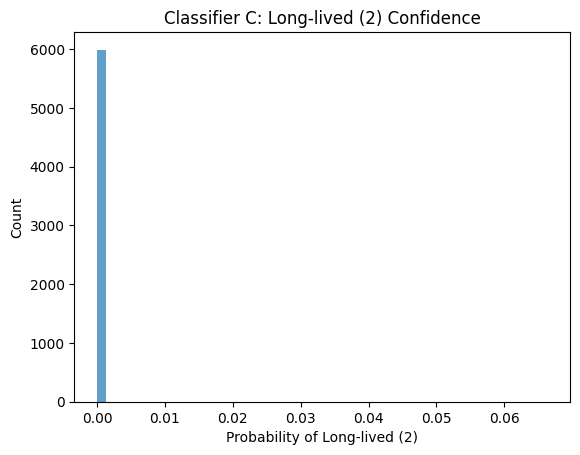

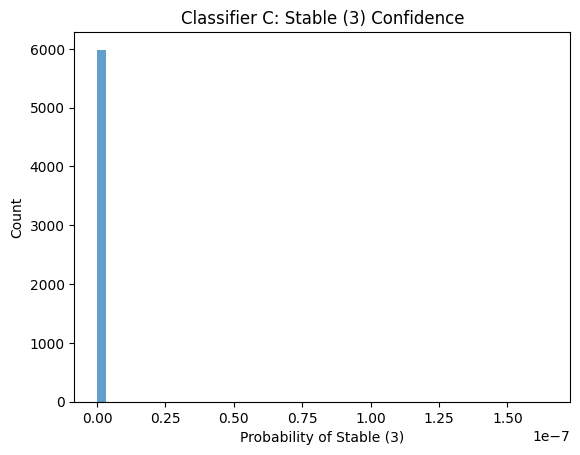

In [30]:
import matplotlib.pyplot as plt

# === Labels for each classifier ===
labels_e_A = ["Prompt Collapse (0)", "Other (1)"]
labels_e_B = ["Prompt (0)", "HMNS (1)", "Stable (2)"]
labels_e_C = ["Prompt (0)", "Short-lived (1)", "Long-lived (2)", "Stable (3)"]

probs = [prob_kn_A, prob_kn_B, prob_kn_C]
titles = [labels_e_A, labels_e_B, labels_e_C]
clf_names = ["Classifier A", "Classifier B", "Classifier C"]

# === Plot histograms ===
for i, (prob, label_list, name) in enumerate(zip(probs, titles, clf_names)):
    for j, label in enumerate(label_list):
        plt.hist(prob[:, j], bins=50, alpha=0.7)
        plt.xlabel(f"Probability of {label}")
        plt.ylabel("Count")
        plt.title(f"{name}: {label} Confidence")
        plt.show()

####EVENT+KN

In [31]:
df_kn = pd.read_csv("GW170817_KN_result.posterior.csv")

df_kn["Mtot"] = df_kn["mass_1_source"] + df_kn["mass_2_source"]
df_kn["Mratio_fixed"] = df_kn["mass_1_source"] / df_kn["mass_2_source"]
df_kn["LambdaTilde"] = (
    (16.0/13.0) * (
        (df_kn["mass_1_source"] + 12.0*df_kn["mass_2_source"]) * df_kn["lambda_1"] +
        (df_kn["mass_2_source"] + 12.0*df_kn["mass_1_source"]) * df_kn["lambda_2"]
    ) / (df_kn["Mtot"]**5)
)
df_kn["ChiEff"] = (
    df_kn["mass_1_source"] * df_kn["a_1"] * df_kn["cos_tilt_1"] +
    df_kn["mass_2_source"] * df_kn["a_2"] * df_kn["cos_tilt_2"]
) / df_kn["Mtot"]

features_kn = ["Mtot", "Mratio_fixed", "LambdaTilde", "ChiEff"]
X_kn_A = scaler_A.transform(df_kn[features_kn].replace([np.inf, -np.inf], np.nan).dropna())
X_kn_B = scaler_B.transform(df_kn[features_kn].replace([np.inf, -np.inf], np.nan).dropna())
X_kn_C = scaler_C.transform(df_kn[features_kn].replace([np.inf, -np.inf], np.nan).dropna())

pred_kn_A = model_A.predict(X_kn_A)
pred_kn_B = model_B.predict(X_kn_B)
pred_kn_C = model_C.predict(X_kn_C)

prob_kn_A = model_A.predict_proba(X_kn_A)
prob_kn_B = model_B.predict_proba(X_kn_B)
prob_kn_C = model_C.predict_proba(X_kn_C)

print("\n--- GW170817 + KN ---")
print("Classifier A:", dict(Counter(pred_kn_A)))
print("Classifier B:", dict(Counter(pred_kn_B)))
print("Classifier C:", dict(Counter(pred_kn_C)))


--- GW170817 + KN ---
Classifier A: {np.int64(0): 5982, np.int64(1): 9}
Classifier B: {np.int64(0): 5983, np.int64(1): 8}
Classifier C: {np.int64(0): 5989, np.int64(1): 1, np.int64(2): 1}


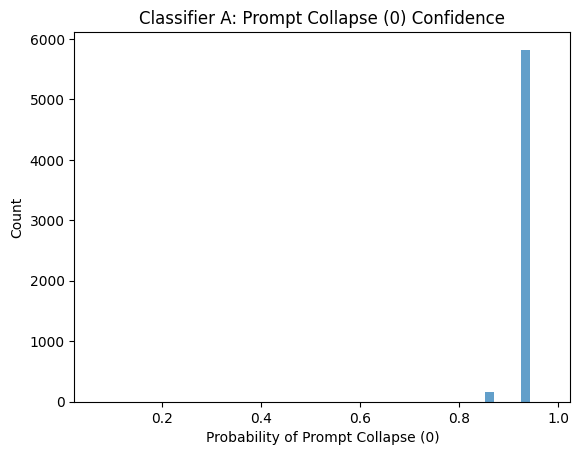

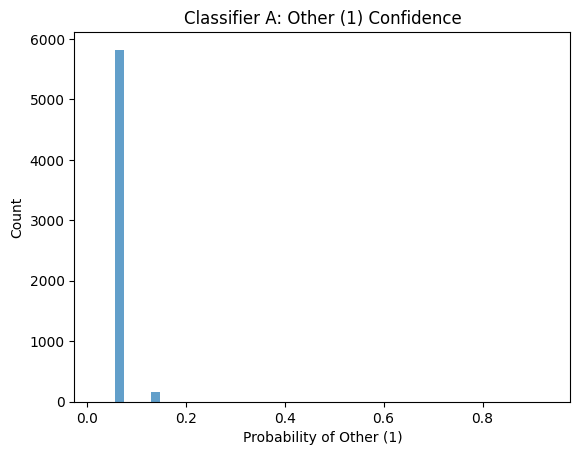

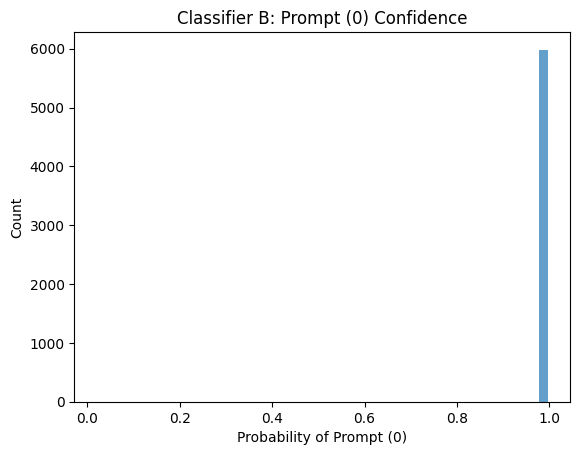

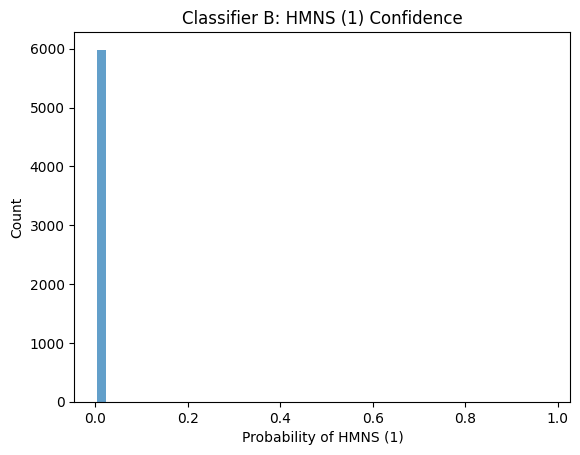

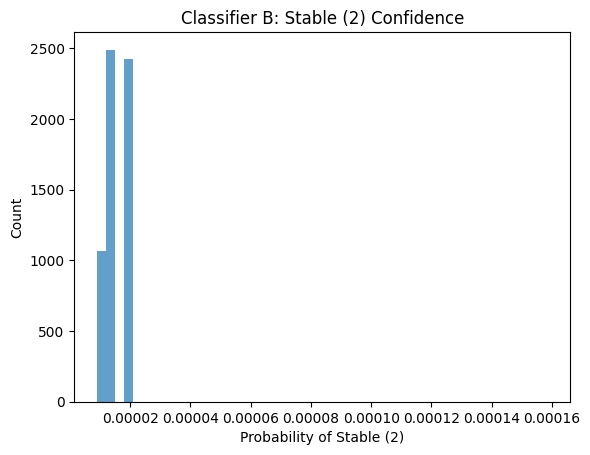

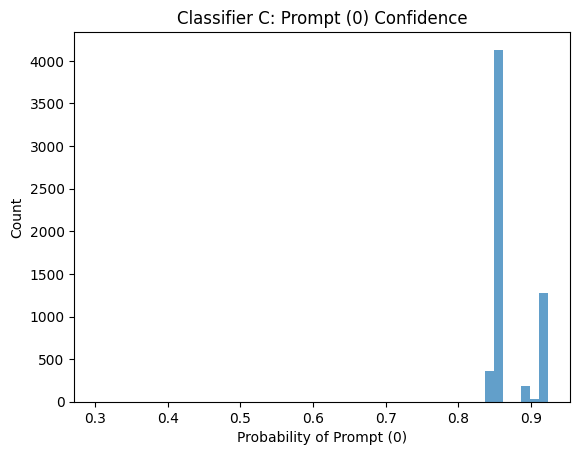

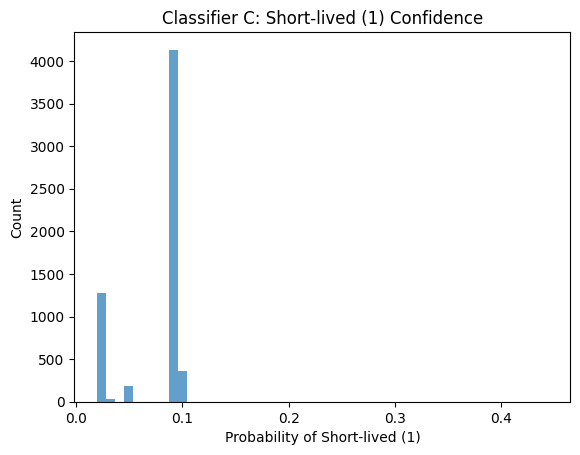

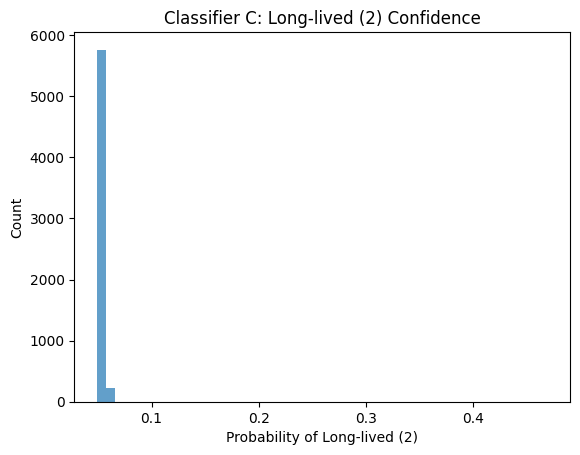

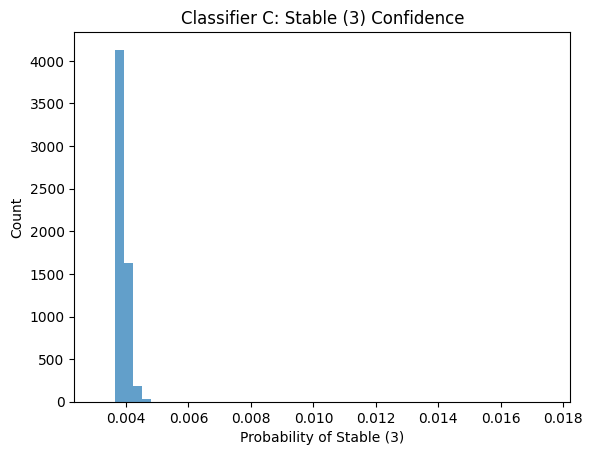

In [32]:
import matplotlib.pyplot as plt

# === Labels for each classifier ===
labelskn_A = ["Prompt Collapse (0)", "Other (1)"]
labelskn_B = ["Prompt (0)", "HMNS (1)", "Stable (2)"]
labelskn_C = ["Prompt (0)", "Short-lived (1)", "Long-lived (2)", "Stable (3)"]

probs = [prob_kn_A, prob_kn_B, prob_kn_C]
titles = [labelskn_A, labelskn_B, labelskn_C]
clf_names = ["Classifier A", "Classifier B", "Classifier C"]

# === Plot histograms ===
for i, (prob, label_list, name) in enumerate(zip(probs, titles, clf_names)):
    for j, label in enumerate(label_list):
        plt.hist(prob[:, j], bins=50, alpha=0.7)
        plt.xlabel(f"Probability of {label}")
        plt.ylabel("Count")
        plt.title(f"{name}: {label} Confidence")
        plt.show()

####EVENT+KN+GRB

In [33]:
df_kn_grb = pd.read_csv("GW170817_KN_GRB_result.posterior.csv")

df_kn_grb["Mtot"] = df_kn_grb["mass_1_source"] + df_kn_grb["mass_2_source"]
df_kn_grb["Mratio_fixed"] = df_kn_grb["mass_1_source"] / df_kn_grb["mass_2_source"]
df_kn_grb["LambdaTilde"] = (
    (16.0/13.0) * (
        (df_kn_grb["mass_1_source"] + 12.0*df_kn_grb["mass_2_source"]) * df_kn_grb["lambda_1"] +
        (df_kn_grb["mass_2_source"] + 12.0*df_kn_grb["mass_1_source"]) * df_kn_grb["lambda_2"]
    ) / (df_kn_grb["Mtot"]**5)
)
df_kn_grb["ChiEff"] = (
    df_kn_grb["mass_1_source"] * df_kn_grb["a_1"] * df_kn_grb["cos_tilt_1"] +
    df_kn_grb["mass_2_source"] * df_kn_grb["a_2"] * df_kn_grb["cos_tilt_2"]
) / df_kn_grb["Mtot"]

features_kn_grb = ["Mtot", "Mratio_fixed", "LambdaTilde", "ChiEff"]
X_kn_grb_A = scaler_A.transform(df_kn_grb[features_kn_grb].replace([np.inf, -np.inf], np.nan).dropna())
X_kn_grb_B = scaler_B.transform(df_kn_grb[features_kn_grb].replace([np.inf, -np.inf], np.nan).dropna())
X_kn_grb_C = scaler_C.transform(df_kn_grb[features_kn_grb].replace([np.inf, -np.inf], np.nan).dropna())

pred_kn_grb_A = model_A.predict(X_kn_grb_A)
pred_kn_grb_B = model_B.predict(X_kn_grb_B)
pred_kn_grb_C = model_C.predict(X_kn_grb_C)

prob_kn_grb_A = model_A.predict_proba(X_kn_grb_A)
prob_kn_grb_B = model_B.predict_proba(X_kn_grb_B)
prob_kn_grb_C = model_C.predict_proba(X_kn_grb_C)

print("\n--- GW170817 + KN + GRB ---")
print("Classifier A:", dict(Counter(pred_kn_grb_A)))
print("Classifier B:", dict(Counter(pred_kn_grb_B)))
print("Classifier C:", dict(Counter(pred_kn_grb_C)))


--- GW170817 + KN + GRB ---
Classifier A: {np.int64(0): 8645, np.int64(1): 4}
Classifier B: {np.int64(0): 8645, np.int64(1): 4}
Classifier C: {np.int64(0): 8649}


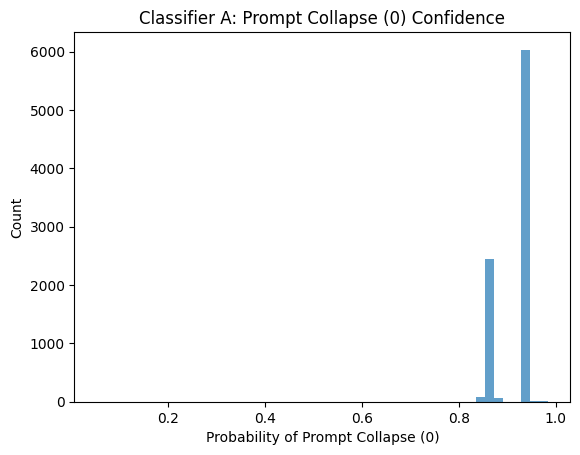

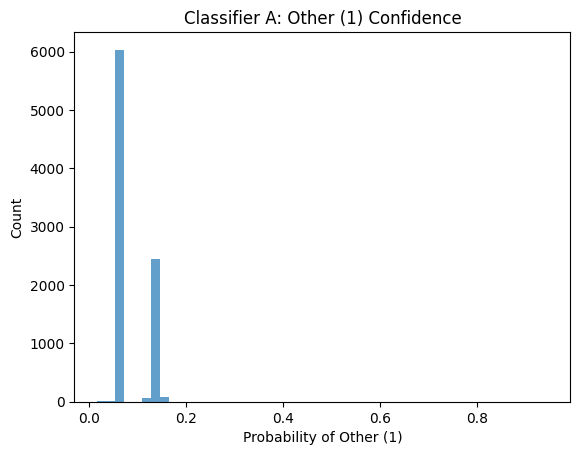

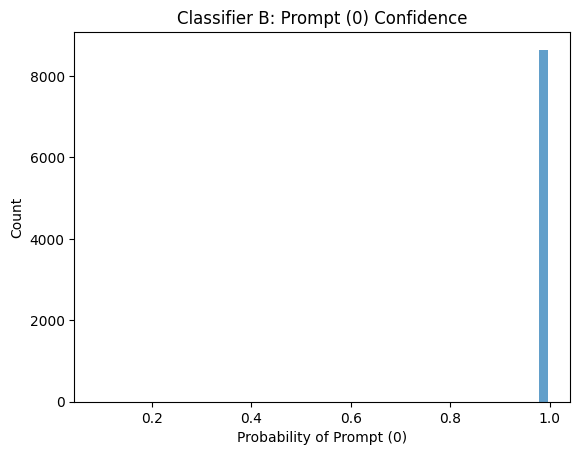

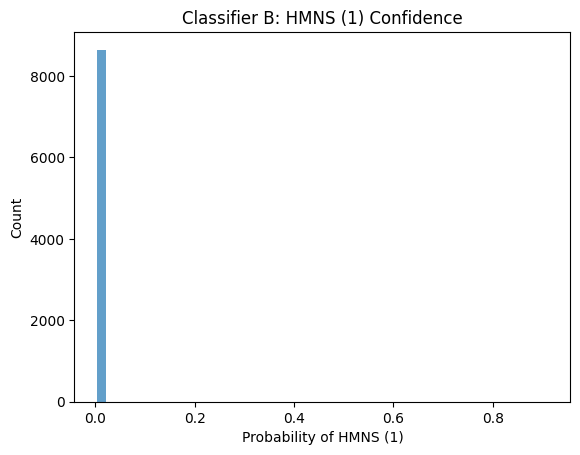

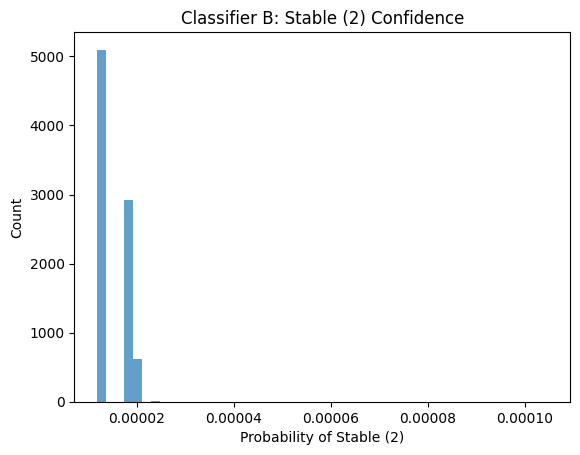

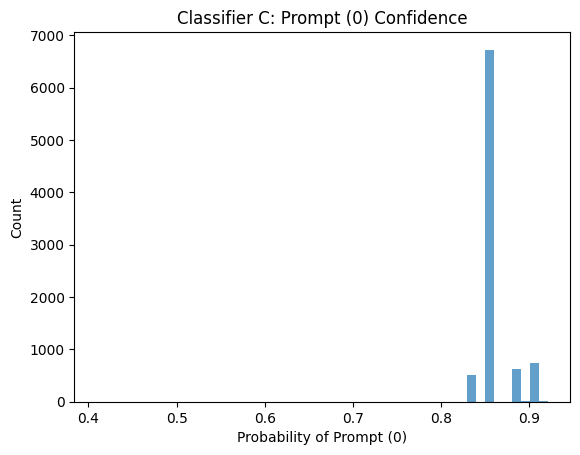

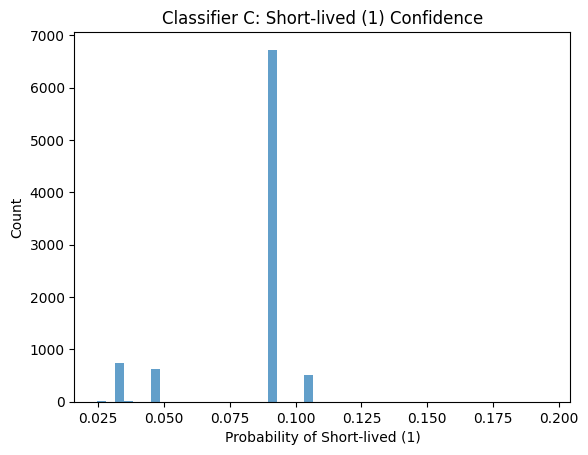

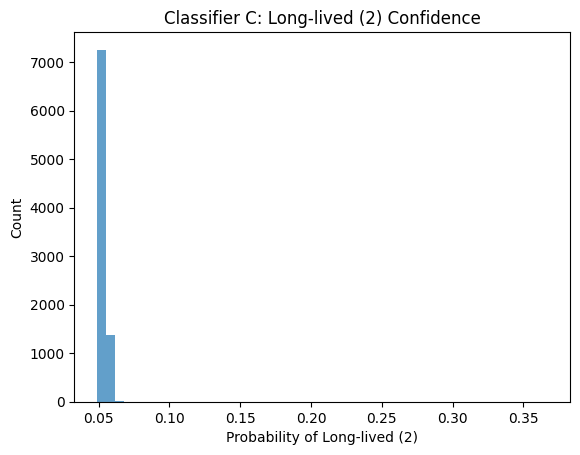

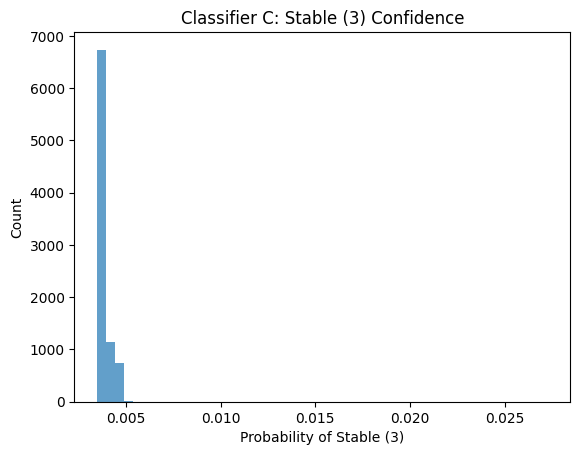

In [34]:
import matplotlib.pyplot as plt

# === Labels for each classifier ===
labelskg_A = ["Prompt Collapse (0)", "Other (1)"]
labelskg_B = ["Prompt (0)", "HMNS (1)", "Stable (2)"]
labelskg_C = ["Prompt (0)", "Short-lived (1)", "Long-lived (2)", "Stable (3)"]

probs = [prob_kn_grb_A, prob_kn_grb_B, prob_kn_grb_C]
titles = [labelskg_A, labelskg_B, labelskg_C]
clf_names = ["Classifier A", "Classifier B", "Classifier C"]

# === Plot histograms ===
for i, (prob, label_list, name) in enumerate(zip(probs, titles, clf_names)):
    for j, label in enumerate(label_list):
        plt.hist(prob[:, j], bins=50, alpha=0.7)
        plt.xlabel(f"Probability of {label}")
        plt.ylabel("Count")
        plt.title(f"{name}: {label} Confidence")
        plt.show()

####GW190425

In [35]:
import pandas as pd
import numpy as np
from collections import Counter

# --- Load ---
df_190425 = pd.read_csv("gw190425_result.posterior.csv")

# --- Derived features (source-frame masses) ---
df_190425["Mtot"] = df_190425["mass_1_source"] + df_190425["mass_2_source"]
df_190425["Mratio_fixed"] = df_190425["mass_1_source"] / df_190425["mass_2_source"]

df_190425["LambdaTilde"] = (
    (16.0/13.0) * (
        (df_190425["mass_1_source"] + 12.0*df_190425["mass_2_source"]) * df_190425["lambda_1"] +
        (df_190425["mass_2_source"] + 12.0*df_190425["mass_1_source"]) * df_190425["lambda_2"]
    ) / (df_190425["Mtot"]**5)
)

df_190425["ChiEff"] = (
    df_190425["mass_1_source"] * df_190425["a_1"] * df_190425["cos_tilt_1"] +
    df_190425["mass_2_source"] * df_190425["a_2"] * df_190425["cos_tilt_2"]
) / df_190425["Mtot"]

# --- Clean ---
features_190425 = ["Mtot", "Mratio_fixed", "LambdaTilde", "ChiEff"]
X_df_190425 = df_190425[features_190425].replace([np.inf, -np.inf], np.nan).dropna()

# --- Scale ---
X_190425_A = scaler_A.transform(X_df_190425)
X_190425_B = scaler_B.transform(X_df_190425)
X_190425_C = scaler_C.transform(X_df_190425)

# --- Predict ---
pred_190425_A = model_A.predict(X_190425_A)
pred_190425_B = model_B.predict(X_190425_B)
pred_190425_C = model_C.predict(X_190425_C)

prob_190425_A = model_A.predict_proba(X_190425_A)
prob_190425_B = model_B.predict_proba(X_190425_B)
prob_190425_C = model_C.predict_proba(X_190425_C)

print("\n--- GW190425 (GW-only) ---")
print("Classifier A:", dict(Counter(pred_190425_A)))
print("Classifier B:", dict(Counter(pred_190425_B)))
print("Classifier C:", dict(Counter(pred_190425_C)))


--- GW190425 (GW-only) ---
Classifier A: {np.int64(0): 65900}
Classifier B: {np.int64(0): 65900}
Classifier C: {np.int64(0): 65900}


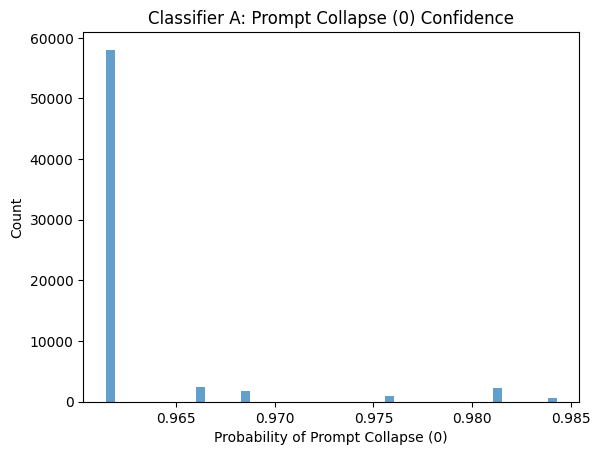

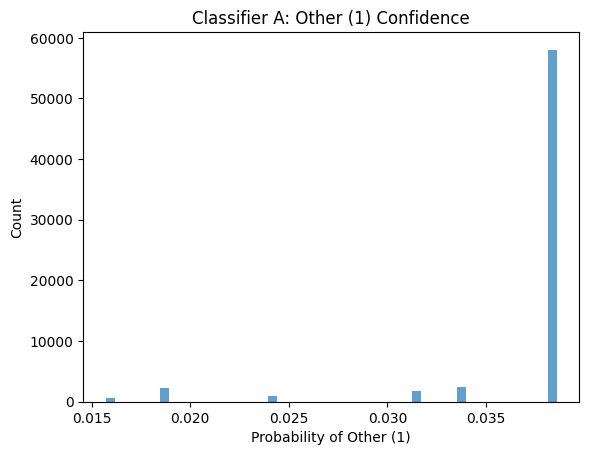

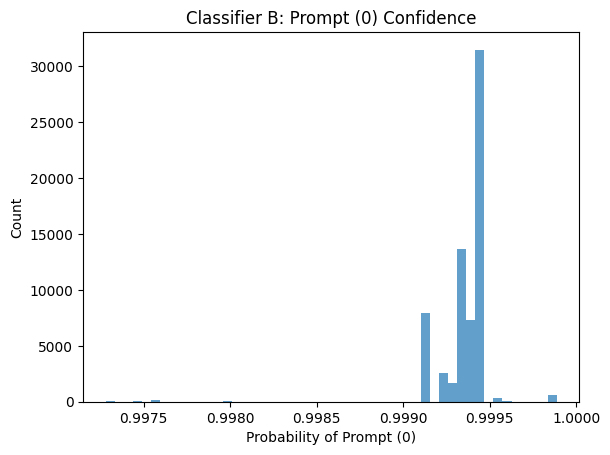

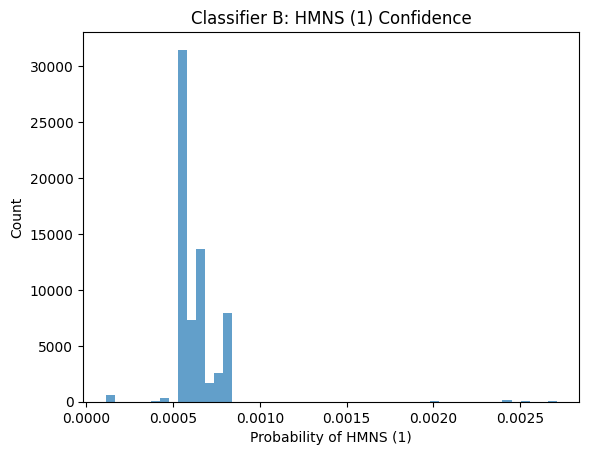

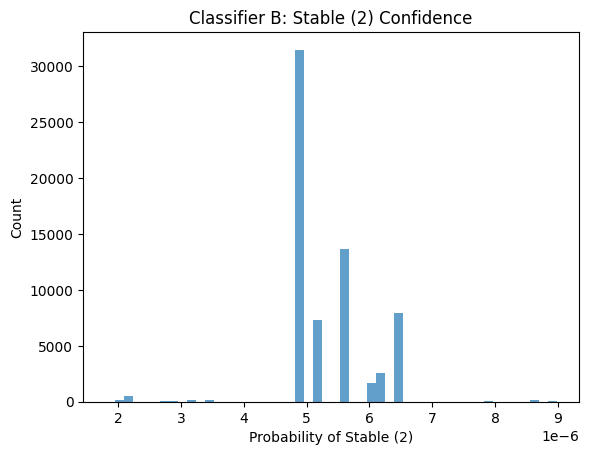

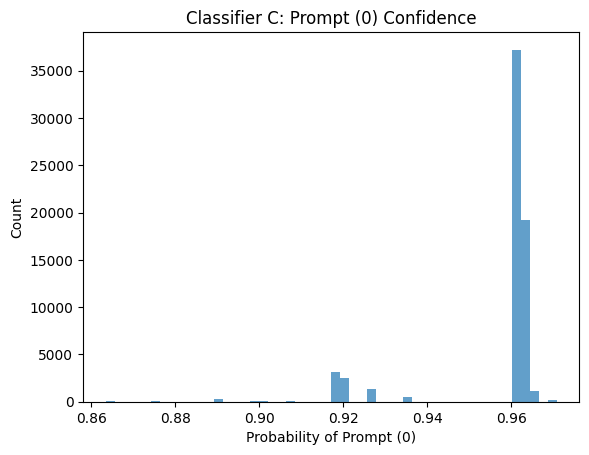

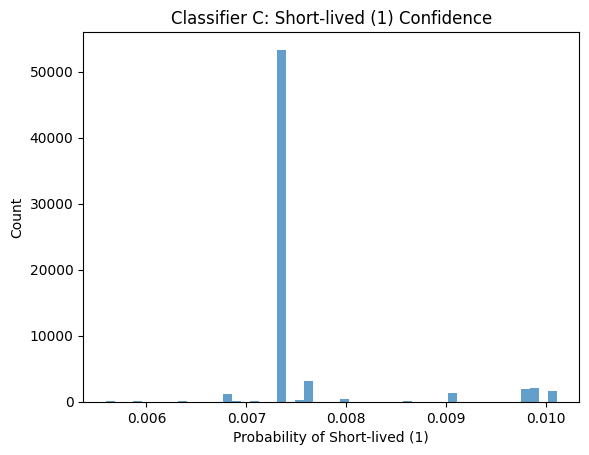

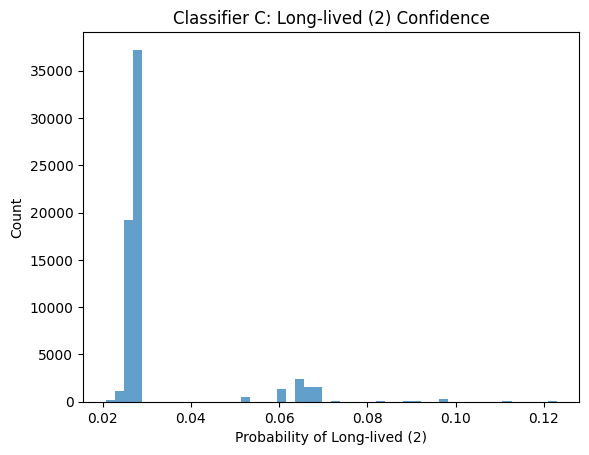

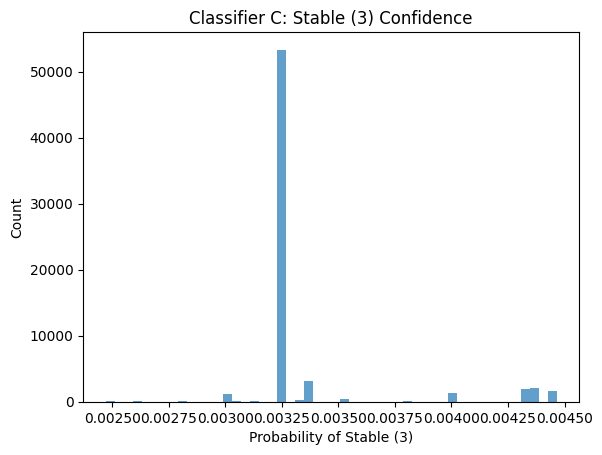

In [36]:
import matplotlib.pyplot as plt

# === Labels for each classifier ===
label_A = ["Prompt Collapse (0)", "Other (1)"]
label_B = ["Prompt (0)", "HMNS (1)", "Stable (2)"]
label_C = ["Prompt (0)", "Short-lived (1)", "Long-lived (2)", "Stable (3)"]

probs = [prob_190425_A, prob_190425_B, prob_190425_C]
titles = [label_A, label_B, label_C]
clf_names = ["Classifier A", "Classifier B", "Classifier C"]

# === Plot histograms ===
for i, (prob, label_list, name) in enumerate(zip(probs, titles, clf_names)):
    for j, label in enumerate(label_list):
        plt.hist(prob[:, j], bins=50, alpha=0.7)
        plt.xlabel(f"Probability of {label}")
        plt.ylabel("Count")
        plt.title(f"{name}: {label} Confidence")
        plt.show()

In [37]:
import pandas as pd
import numpy as np

# Helper to format as percentage string
def fmt(p):
    return f"{100 * p:.1f}%"

# === Classifier A (2 classes assumed: index 0,1) ===
A_17      = np.mean(prob_17_A, axis=0)         # GW170817 (GW-only)
A_eos     = np.mean(prob_eos_A, axis=0)        # GW170817 + EoS
A_kn      = np.mean(prob_kn_A, axis=0)         # GW170817 + KN
A_kn_grb  = np.mean(prob_kn_grb_A, axis=0)     # GW170817 + KN + GRB
A_190425  = np.mean(prob_190425_A, axis=0)     # GW190425 (GW-only)

# === Classifier B (3 classes assumed: index 0,1,2) ===
B_17      = np.mean(prob_17_B, axis=0)
B_eos     = np.mean(prob_eos_B, axis=0)
B_kn      = np.mean(prob_kn_B, axis=0)
B_kn_grb  = np.mean(prob_kn_grb_B, axis=0)
B_190425  = np.mean(prob_190425_B, axis=0)

# === Classifier C (4 classes assumed: index 0,1,2,3) ===
C_17      = np.mean(prob_17_C, axis=0)
C_eos     = np.mean(prob_eos_C, axis=0)
C_kn      = np.mean(prob_kn_C, axis=0)
C_kn_grb  = np.mean(prob_kn_grb_C, axis=0)
C_190425  = np.mean(prob_190425_C, axis=0)

# === Final Summary Table ===
summary_table = pd.DataFrame({
    "Event": [
        "GW170817 (GW-only)",
        "GW170817 + EoS",
        "GW170817 + KN",
        "GW170817 + KN + GRB",
        "GW190425 (GW-only)",
    ],
    # Classifier A
    "p_PCBH_A": [fmt(A_17[0]), fmt(A_eos[0]), fmt(A_kn[0]), fmt(A_kn_grb[0]), fmt(A_190425[0])],
    "p_RNS_A":  [fmt(A_17[1]), fmt(A_eos[1]), fmt(A_kn[1]), fmt(A_kn_grb[1]), fmt(A_190425[1])],

    # Classifier B
    "p_PCBH_B": [fmt(B_17[0]), fmt(B_eos[0]), fmt(B_kn[0]), fmt(B_kn_grb[0]), fmt(B_190425[0])],
    "p_HMNS_B": [fmt(B_17[1]), fmt(B_eos[1]), fmt(B_kn[1]), fmt(B_kn_grb[1]), fmt(B_190425[1])],
    "p_NC_B":   [fmt(B_17[2]), fmt(B_eos[2]), fmt(B_kn[2]), fmt(B_kn_grb[2]), fmt(B_190425[2])],

    # Classifier C
    "p_PCBH_C":  [fmt(C_17[0]), fmt(C_eos[0]), fmt(C_kn[0]), fmt(C_kn_grb[0]), fmt(C_190425[0])],
    "p_SHORT_C": [fmt(C_17[1]), fmt(C_eos[1]), fmt(C_kn[1]), fmt(C_kn_grb[1]), fmt(C_190425[1])],
    "p_LONG_C":  [fmt(C_17[2]), fmt(C_eos[2]), fmt(C_kn[2]), fmt(C_kn_grb[2]), fmt(C_190425[2])],
    "p_NC_C":    [fmt(C_17[3]), fmt(C_eos[3]), fmt(C_kn[3]), fmt(C_kn_grb[3]), fmt(C_190425[3])],
})

print("\nMerger Outcome Probability Table:")
display(summary_table)


Merger Outcome Probability Table:


,Event,p_PCBH_A,p_RNS_A,p_PCBH_B,p_HMNS_B,p_NC_B,p_PCBH_C,p_SHORT_C,p_LONG_C,p_NC_C
0,GW170817 (GW-only),90.0%,10.0%,98.1%,1.9%,0.0%,86.6%,7.4%,5.6%,0.4%
1,GW170817 + EoS,90.1%,9.9%,98.6%,1.4%,0.0%,87.4%,6.7%,5.5%,0.4%
2,GW170817 + KN,92.7%,7.3%,99.2%,0.8%,0.0%,86.9%,7.6%,5.1%,0.4%
3,GW170817 + KN + GRB,90.7%,9.3%,99.2%,0.8%,0.0%,86.1%,8.4%,5.1%,0.4%
4,GW190425 (GW-only),96.3%,3.7%,99.9%,0.1%,0.0%,95.7%,0.8%,3.2%,0.3%
